# Aufgabe 4 - Partitionierende Clusteranalyse und Klassifikationsbäume

## a. Generierung der Datensätze

In [1]:
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
import pandas as pd
import numpy as np
%matplotlib inline

X, y = make_blobs(n_samples=1000, n_features=5, centers=4, cluster_std=3, random_state=2)
df = pd.DataFrame({'Feature1':X[:,0],'Feature2':X[:,1],'Feature3':X[:,2],'Feature4':X[:,3],'Feature5':X[:,4],'center':y})
data = pd.DataFrame(df)
data.head()

Feature1   Feature2   Feature3  Feature4   Feature5  center
0 -3.534226 -10.225905   1.273965 -3.512373  -4.429899       0
1 -3.266729 -12.552020  -0.351275 -8.809927   3.885339       0
2  3.402042   3.223843  -8.617246  2.043355  -7.486247       2
3  3.545748   4.811711  -0.573052  5.225159 -11.425259       3
4  4.219865   3.626152 -11.462489  3.606884  -6.223801       2

### b. Visualisierung

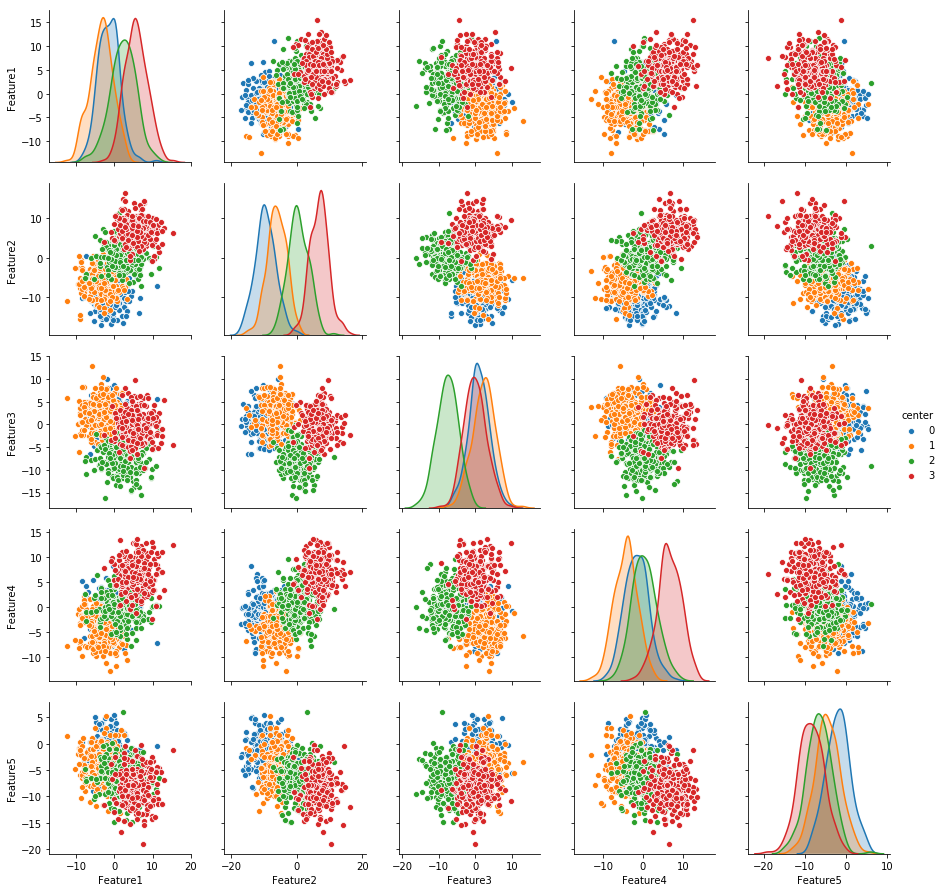

In [2]:
import seaborn as sns

sns.pairplot(data, vars=data.columns[:-1], hue='center')

## Partitionierendes Clustering

### c. partitionierendes Clustering nach k-Means-Verfahren

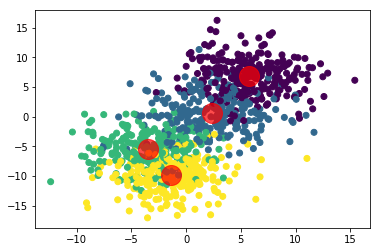

In [3]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=4, random_state=2) # RS = 2
kmean_fit = kmean.fit(X)
y_kmean = kmean.predict(X)

pyplot.scatter(X[:,0], X[:,1], c=y_kmean)
centers = kmean.cluster_centers_
pyplot.scatter(centers[:,0], centers[:,1], c='red', s=400, alpha=0.7)

### d. Berechnung der Genauigkeit des Clustering als Anteil der korrekt zugeordneten Datensätze

In [4]:
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.stats import mode

y_kmean_labels = np.zeros_like(y_kmean)

for i in range (4):
    mask = (y_kmean == i)
    y_kmean_labels[mask] = mode(y[mask])[0]
print(accuracy_score(y, y_kmean_labels))

0.89


### e. Konfusionsmatrix

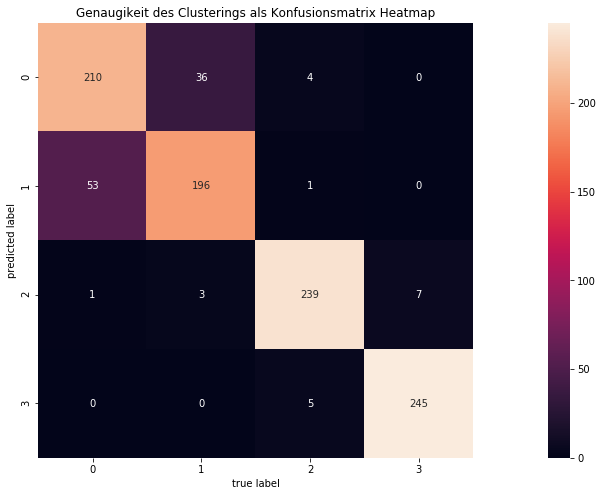

In [5]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_kmean_labels)


pyplot.figure(figsize=(27, 8))
sns.heatmap(cm, cbar=True, square=True, annot=True, fmt='d')
pyplot.xlabel('true label')
pyplot.ylabel('predicted label')
pyplot.title('Genaugikeit des Clusterings als Konfusionsmatrix Heatmap');

Durch die Clusteranalyse mit dem k-means Verfahren, ergibt sich bereits eine recht genaue Klassifikation, obwohl das Verfahren hierfür nicht gedacht ist. In der Heatmap ist zu erkennen, dass der größte Teil der Falschzuordnungen im Vergleich zu den Labels stattfindet, wenn center "0" und center "1" zu unterscheiden sind. Dieses Verhalten war zu erwarten, denn wenn man sich das Streuungsdiagramm nach der Clusterfindung ansieht, sieht man das die genannten Cluster am nähesten Zusammenliegen und am stärksten untereinander vermischt sind.

## Klassifikationsbaum

### f. Teilung der Datensätze

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### g. Trainieren eines Klassifikationsbaumes

In [7]:
from sklearn.tree import DecisionTreeClassifier


tree_clf = DecisionTreeClassifier(criterion="gini", min_impurity_decrease = 0.05, random_state=2)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred_tree)

0.795

### h. Visualisierung des Baumes

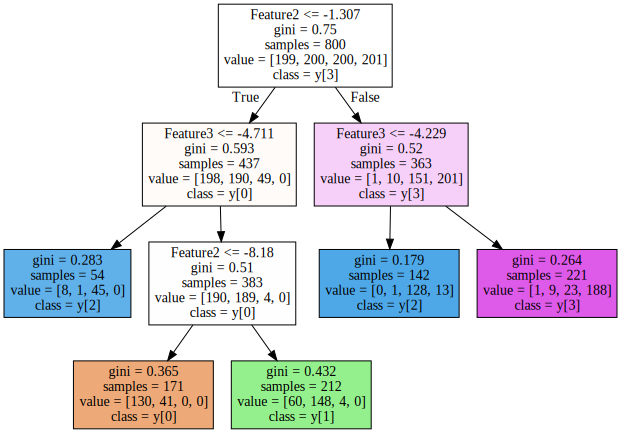

In [8]:
from graphviz import Source
from sklearn.tree import export_graphviz as gvz_export
Source(gvz_export(tree_clf, feature_names=data.columns.values[:5], class_names=True, filled=True, out_file=None))

## Interpretation

Bei der Struktur des Baumes ist hier zu erkennen, dass die Werte des Feature2 und des Feature3, die größte Bedeutung zuzuweisen ist. Entscheidungen, wie der Datensatz zu interpretieren ist, werden ausschließlich, bei diesem Verfahren, über diese Werte getroffen. Es ist also außerordentlich gut nachzuvollziehen, warum welcher Datensatz wie klassifiziert wurde. Da wir Datensätze erzeugt haben, die 4 centers zuzuordnen sind, sieht man am Ende in den Values, die getroffenen Zuordnungen und auch möglicherweise die Falschzuordnungen, bzw. die Unsicherheiten und vor allem auch die Klassifizierung in eben 4 Klassen.


### i. Berechnung der Unreinheit nach Gini für den ersten Knoten

In [9]:
g = 1-((199/800)**2 + (200/800)**2 + (200/800)**2 + (201/800)**2)
print('Gini-Index des Wurzelknotens ' + str(g))

Gini-Index des Wurzelknotens 0.749996875


### j. Berechnung der Verbesserung durch den ersten Split

In [10]:
gRight = 1-((1/363)**2 + (10/363)**2 + (151/363)**2 + (201/363)**2)

gLeft = 1-((198/437)**2 + (190/437)**2+ (49/437)**2 + (0/437)**2)

verbesserung = g - 437/800*gLeft - 363/800*gRight
print('Gini-Index des linken Knotens: ' + str(gLeft))
print('Gini-Index des rechten Knotens: ' + str(gRight))
print('Verbesserung: ' + str(verbesserung))

Gini-Index des linken Knotens: 0.5931014981489142
Gini-Index des rechten Knotens: 0.5195911026113881
Verbesserung: 0.19025071882623826


### k. Test der Genauigkeit

[[33 16  1  1]
 [13 36  0  1]
 [ 0  3 45  2]
 [ 0  0  4 45]]
0.795


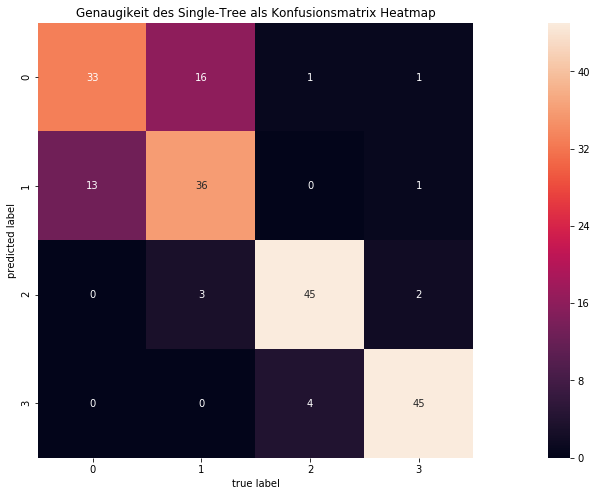

In [11]:
y_test_pred = tree_clf.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
matrix = confusion_matrix(y_test, y_test_pred)
print(matrix)
print(acc)
pyplot.figure(figsize=(27, 8))
sns.heatmap(matrix, cbar=True, square=True, annot=True, fmt='d')
pyplot.xlabel('true label')
pyplot.ylabel('predicted label')
pyplot.title('Genaugikeit des Single-Tree als Konfusionsmatrix Heatmap');

## Random-Forest-Klassifikator

### l. Trainieren von 20 Bäumen

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf_c = RandomForestClassifier(n_estimators=20, random_state=2)

rf_c.fit(X_train, y_train)
y_pred_rf = rf_c.predict(X_test)

## m. Testen der Genauigkeit und Ausgabe der Konfusionsmatrix

0.88
[[42  8  1  0]
 [12 38  0  0]
 [ 0  2 48  0]
 [ 0  0  1 48]]


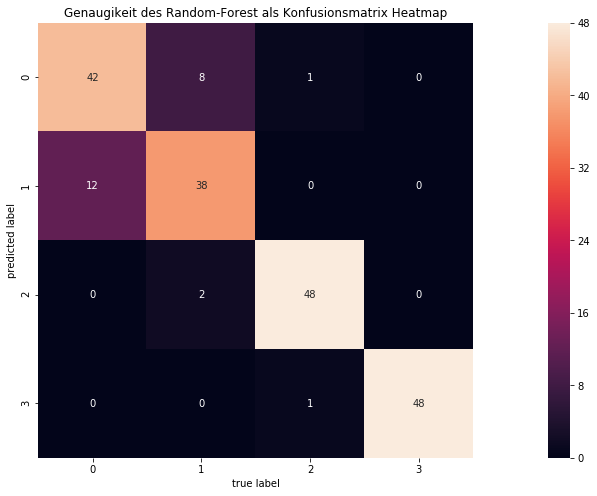

In [13]:
rf_acc = accuracy_score(y_test, y_pred_rf)
print (rf_acc)

cmatrix = confusion_matrix(y_test, y_pred_rf)
print(cmatrix)
pyplot.figure(figsize=(27, 8))
sns.heatmap(cmatrix, cbar=True, square=True, annot=True, fmt='d')
pyplot.xlabel('true label')
pyplot.ylabel('predicted label')
pyplot.title('Genaugikeit des Random-Forest als Konfusionsmatrix Heatmap');

## n. Erzeugung eines Berichts für die Klassifikation und Erklärung der Begriffe

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_test , y_pred = y_pred_rf) )

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        51
           1       0.79      0.76      0.78        50
           2       0.96      0.96      0.96        50
           3       1.00      0.98      0.99        49

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



## Begriffsklärung
### precision

Präzision ist das Verhältnis der positiven Klassifikationen zu der Gesamtheit aller Klassifikationen.

Berechnungsvorschrift:

TP = True Positives
FP = False Positives

Präzision = TP/(TP+FP)

### recall

Der Recall ist der Anteil der eingeordneten Datensätze, die auch korrekt eingeordnet/belabelt wurden.
Synonyme: "sensitivity", "true positive rate"

Berechnungsvorschrift:

FN – False Negatives

Recall = TP/(TP+FN)

### f1-score

Der F1-Score ist ein Hilfsmittel um Klassifizierer zu vergleichen. Der F1-Score ist abhängig von der Präzision und dem recall. Er wird erstellt, indem man das harmonische Mittel von Präzision und recall ermittelt wird.

Berechnungsvorschrift:

F1 = 2 x (precision x recall)/(precision + recall)

### support

Support ist die Anzahl der Vorkommen der jeweiligen Klassen in y_true.

### accuracy

Die Genauigkeit mit der die Klassifikation erfolgt ist.

### macro avg

Im macro avg wird der Durchschnitt der Leistung der Klassifizierung jeder einzelnen Klasse gebildet. 

### weighted avg

Falls man den Durchschnitt nach Relevanz gewichten möchte, erhält man hier den entsprechenden Output.
